In [ ]:
## Connect google colab with google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
#Membuat dataset dari list file di dalam folder training

import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split

def make_csv(x,y,name_csv):
    """function untuk membuat csv dari dictionary"""
    df = {"images_id":x,"labels":y}
    df = pd.DataFrame(df)
    df.to_csv(name_csv,index=False)\

class_list = ["training/CC","training/L"] # List directory dari folder images

image_paths = [] # list images path untuk membuat dictionary
label_list = [] # list label dari images path untuk membuat dictionary
    
for class in class_list:
    img_list = os.listdir(class)
    for i,img in enumerate(img_list):
        img_list[i] = class+"/"+img
        kelas = class.replace("training/","")
        label_list.append(kelas)
    image_paths = image_paths + img_list


df = {"images_id":image_paths,"labels":label_list} # Dictionary untuk membuat file csv
df = pd.DataFrame(df)

df = df.sample(frac=1).reset_index(drop=True) # Mengambil sample 100% dari dataset untuk randomize csv sebelum di split

x = df.images_id
y = df.labels

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.15,stratify=y) # split dataset untuk training dan testing

make_csv(x_train,y_train,"train.csv")
make_csv(x_test,y_test,"test.csv")

In [ ]:
!mkdir training
!unzip /content/drive/MyDrive/training.zip -d /content/training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Input, Activation, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import cv2

Menentukan mode fine-tuning dari model pretraining InceptionV3 (finetune-all, freeze_all, certain layer)

In [ ]:
def set_trainable(model, transfer_criteria = 'finetune_all', print_details = False):

  #freeze all layers
  if transfer_criteria == 'freeze_all':
    for layer in model.layers:
      layer.trainable = False
      
      if print_details == True:
        print('layer name: {}, trainable {}'.format(layer.name, layer.trainable))

  #finetune all layers
  elif transfer_criteria == 'finetune_all':
    for layer in model.layers:
      layer.trainable = True

      if print_details == True:
        print('layer name: {}, trainable {}'.format(layer.name, layer.trainable))
  
  #set layers trainable from the specified layer up to the last layer
  else:
    trainable_condition = False
    for layer in model.layers:
      if layer.name == transfer_criteria:
        trainable_condition = True
      layer.trainable = trainable_condition

      if print_details == True:
        print('layer name: {}, trainable {}'.format(layer.name, layer.trainable))

In [ ]:
def plt_model(model):
  """plot model ke dalam bentuk png"""
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

def create_transfer_learning_model(transferred_model):
    """membuat model transfer learning dari pretraining menjadi model klasifikasi anggrek"""
  x = transferred_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = Dense(2, activation='softmax')(x)
  model = Model(transferred_model.input, x)
  return model

Initialize Model InceptionV3 dengan weight ImageNet dan transfer criteria di layer mixed9

In [ ]:
inception =  InceptionV3(include_top= False, 
                         weights = 'imagenet',input_tensor = None, 
                         input_shape = (75,75,3),
                         pooling = None)

set_trainable(inception, transfer_criteria = 'mixed9', print_details = True)

In [ ]:
model = create_transfer_learning_model(inception)

In [ ]:
model.summary()

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
len(test_df)

87

Augmentasi data menggunakan ImageDataGenerator, lalu membuat data generator untuk train dan validasi berdasarkan data csv

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  validation_split = 0.25,
                                  zoom_range=0.1,  
                                  horizontal_flip=True,
                                  vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = None,
                                                    x_col="images_id",
                                                    y_col="labels",
                                                    target_size=(75,75),
                                                    color_mode="rgb",
                                                    class_mode="categorical",
                                                    batch_size=32, 
                                                    shuffle=True,
                                                    subset="training")

valid_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col="images_id",
                                                    y_col="labels",
                                                    directory = None,
                                                    target_size=(75,75),
                                                    color_mode="rgb",
                                                    class_mode="categorical",
                                                    batch_size=32, 
                                                    shuffle=True,
                                                    subset="validation")

Found 369 validated image filenames belonging to 2 classes.
Found 122 validated image filenames belonging to 2 classes.


Membuat data generator untuk data testing

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
data_flow_test = test_datagen.flow_from_dataframe(test_df,
                                                  x_col="images_id",
                                                  y_col="labels",
                                                  target_size= (75,75),
                                                  color_mode = 'rgb', 
                                                  class_mode = 'categorical',
                                                  batch_size = 1, 
                                                  seed=1)

Found 87 validated image filenames belonging to 2 classes.


In [ ]:
len(data_flow_train)

15

EarlyStopping = proses training berhenti ketika akurasi validasi tidak turun selama {patience} epoch

ReduceLROnPlateau =  learning rate dari training akan turun ketika akurasi validasi tidak turun selama {patience} epoch

ModelCheckpoint = akan menyimpan checkpoint ketika akurasi validasi mencapai titik tertinggi ketika training

In [ ]:
es = EarlyStopping(monitor='val_accuracy', 
                   mode='min', 
                   verbose=1, 
                   patience=50)

mc = ModelCheckpoint('best_checkpoint.h5', 
                     monitor='val_accuracy', 
                     mode='max', 
                     verbose=1,
                     save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.04, verbose=1,mode="min",patience=10)

Loss menggunakan CategoricalCrossentropy karena data berupa category (Cornu-cervi, Lamelligera)
Optimizer menggunakan adam dengan Learning rate 0.001 dan metrics yang digunakan adalah akurasi

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam(lr = 0.001)
model.compile(optimizer= opt, 
              loss = loss, 
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Proses Training menggunakan 100 epoch

In [ ]:
history = model.fit(data_flow_train, 
                    validation_data= data_flow_val,
                    validation_steps = 1, 
                    steps_per_epoch = m_train/BATCH_SIZE,
                    callbacks=[mc, es,reduce_lr],
                    epochs = 100)

Epoch 1/100
14/14 [==============================] - 8s 193ms/step - loss: 0.7871 - accuracy: 0.7869 - val_loss: 1.5644 - val_accuracy: 0.8438

Epoch 00001: val_accuracy improved from -inf to 0.84375, saving model to checkpoint_0.84375.h5
Epoch 2/100
14/14 [==============================] - 1s 75ms/step - loss: 0.2414 - accuracy: 0.9283 - val_loss: 1.2747 - val_accuracy: 0.8438

Epoch 00002: val_accuracy did not improve from 0.84375
Epoch 3/100
14/14 [==============================] - 1s 73ms/step - loss: 0.0586 - accuracy: 0.9768 - val_loss: 4.3027 - val_accuracy: 0.7500

Epoch 00003: val_accuracy did not improve from 0.84375
Epoch 4/100
14/14 [==============================] - 1s 73ms/step - loss: 0.0950 - accuracy: 0.9684 - val_loss: 3.9134 - val_accuracy: 0.6562

Epoch 00004: val_accuracy did not improve from 0.84375
Epoch 5/100
14/14 [==============================] - 1s 75ms/step - loss: 0.0703 - accuracy: 0.9852 - val_loss: 3.2847 - val_accuracy: 0.7188

Epoch 00005: val_accurac

Memilih model dari akurasi validasi tertinggi

In [1]:
selected_model = keras.models.load_model('content/best_checkpoint.h5')

In [ ]:
# selected_model = keras.models.load_model('best_model.h5')
tf.keras.models.save_model(selected_model,'model_putik.hdf5')

Evaluasi model terbaik dari data testing

In [ ]:
selected_model.evaluate(data_flow_test,return_dict=True)

87/87 [==============================] - 1s 17ms/step - loss: 0.1473 - accuracy: 0.9655


{'accuracy': 0.9655172228813171, 'loss': 0.1473056524991989}

Hasil testing model dengan data testing mempunyai akurasi sebesar 96.55%

Membuat plot dari proses training

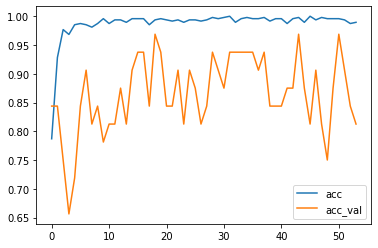

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['acc', 'acc_val'])
plt.show()